# Project Phase 2

Team Members: Kate Li (kl739), Audrey Holden (aeh252), Katherine Yee (ky424), Julian Correa (jfc297)

## Research Question

Question: What factors predict an NBA player’s salary? Is there a relationship between an NBA player's performance and an increase in their salary? 

In this assignment we will be analyzing how the salaries of NBA players change depending on many different statistical variables, including points, assists, rebounds, blocks, steals, etc, per game. We will train a multivariable regression to see if we can predict an NBA player's salary depending on their previous season(s) performance statistics. Our model will hopefully help sports analysts better predict a contract that an NBA player may receive. It may also provide NBA team managers more insight into team spending and budgeting. 

We will also see if there is a positive or negative correlation between performance and salary. 
We also plan on analyzing different NBA player positions and examining the magnitude of salary changes depending on their respective stats. For example, a center having an increase in blocks per game may improve their salary, but a comparative increase in points per game by a shooting guard would most likely result in a dramatic increase in their salary given that offensive roles are more valuable.

## Data Collection and Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb
import requests
from bs4 import BeautifulSoup
import time

We read the dataset (csv) files and stored them in variables. `salaries` has data on NBA player salaries by year from 1990-2017. `stats` has data on NBA player performance statistics by year from 1950-2017.

In [2]:
salaries = pd.read_csv("salaries.csv")
stats = pd.read_csv("stats.csv")
playoffs = pd.read_csv("playoffs.csv")

### Data Cleaning for salaries_df

We created a pandas dataframe using the `salaries` csv file and assigned it to the variable `salaries_df`. We then dropped miscellaneous columns such as `Register Value`, `Season End`, and `Full Team Name`. 

In [3]:
salaries_df = pd.DataFrame(salaries)
salaries_df = salaries_df.drop(['Register Value', 'Season End', 'Full Team Name'], \
                               axis = 1)
print(salaries_df)

              Player Name     Salary in $   Season Start Team
0              A.C. Green   $1,750,000.00           1990  LAL
1              A.C. Green   $1,750,000.00           1991  LAL
2              A.C. Green   $1,750,000.00           1992  LAL
3              A.C. Green   $1,885,000.00           1993  PHO
4              A.C. Green   $6,472,600.00           1994  PHO
...                   ...              ...           ...  ...
11832  Zydrunas Ilgauskas   $8,740,000.00           2005  CLE
11833  Zydrunas Ilgauskas   $9,442,697.00           2006  CLE
11834  Zydrunas Ilgauskas  $10,142,156.00           2007  CLE
11835  Zydrunas Ilgauskas  $10,841,615.00           2008  CLE
11836  Zydrunas Ilgauskas  $11,541,074.00           2009  WAS

[11837 rows x 4 columns]


Here, we renamed the column `Player Name` to just `Player` and the `Season Start` column to just `Season`. We then selected only the players that have salaries listed between the years 2010 and 2017 (inclusive). We also dropped rows where the player was listed twice in one year but with different teams, meaning we disregard mid-season trading.

In [4]:
salaries_df = salaries_df.rename(columns = {'Player Name': 'Player', \
                    ' Salary in $ ': 'Salary', 'Season Start': 'Season'})

salaries_df = salaries_df[(salaries_df['Season'] >= 2010) & \
                        (salaries_df['Season'] <= 2017)]

salaries_df = salaries_df.drop_duplicates(subset = \
                                    ['Player', 'Season'], keep = 'first')

print(salaries_df)

              Player          Salary  Season Team
19      A.J. Hammons    $650,000.00     2016  DAL
20      A.J. Hammons  $1,312,611.00     2017  MIA
22        A.J. Price    $762,195.00     2010  IND
23        A.J. Price    $854,389.00     2011  IND
24        A.J. Price    $885,120.00     2012  WAS
...              ...             ...     ...  ...
11805  Zaza Pachulia  $2,898,000.00     2016  GSW
11806  Zaza Pachulia  $3,477,600.00     2017  GSW
11817        Zhou Qi    $815,615.00     2017  HOU
11818   Zoran Dragic  $1,962,103.00     2014  MIA
11819   Zoran Dragic  $2,050,397.00     2015  BOS

[3710 rows x 4 columns]


We wanted to ensure that we only selected the players that were active during the entire time frame that we selected (2010 to 2017 seasons). In order to do so, we counted the number of times each player was listed within `salaries_df` which had already been filtered to have data only within this time frame. 

We converted this count into a dataframe that included the player and the number of times they were counted (which was always 8). Performing an inner join on the player, we were able to modify the original `salaries_df` so that it included all of the salaries for each player from 2010 to 2017 inclusive. This dataframe now has only players that were active from 2010 to 2017 (inclusive) and includes player name, the season, salaries, and team. 

In [5]:
for i in salaries_df:
    player_count = salaries_df['Player'].value_counts()
    select = player_count[player_count == 8]

filter_players_df = pd.DataFrame(select)
filter_players_df = filter_players_df.reset_index()

salaries_df = duckdb.sql("""SELECT salaries_df.Player, \
                                salaries_df.Salary, salaries_df.Season, \
                                salaries_df.Team
                             FROM salaries_df 
                             INNER JOIN filter_players_df
                             ON salaries_df.Player = filter_players_df.Player \
                        """).df()

# remove special characters '$' and ',' from salary values and convert values to floats
salaries_df['Salary'] = salaries_df['Salary'].replace(r'[^\d.]', '', regex = True).astype(float)

salaries_df.to_csv('cleaned_salaries_df.csv', index = False)

print(salaries_df)
print(salaries_df.iloc[:8, :])

            Player      Salary  Season Team
0       Aaron Gray   1028840.0    2010  NOH
1       Aaron Gray   2500000.0    2011  TOR
2       Aaron Gray   2575000.0    2012  TOR
3       Aaron Gray   2690875.0    2013  TOR
4       Aaron Gray   1227985.0    2014  DET
..             ...         ...     ...  ...
827  Ryan Anderson   8308500.0    2013  NOH
828  Ryan Anderson   8491500.0    2014  NOH
829  Ryan Anderson   8500000.0    2015  NOH
830  Ryan Anderson  18735364.0    2016  HOU
831  Ryan Anderson  19578455.0    2017  HOU

[832 rows x 4 columns]
       Player     Salary  Season Team
0  Aaron Gray  1028840.0    2010  NOH
1  Aaron Gray  2500000.0    2011  TOR
2  Aaron Gray  2575000.0    2012  TOR
3  Aaron Gray  2690875.0    2013  TOR
4  Aaron Gray  1227985.0    2014  DET
5  Aaron Gray   452059.0    2015  DET
6  Aaron Gray   452059.0    2016  DET
7  Aaron Gray   452059.0    2017  DET


### Data Cleaning for stats_df

In this cell, we are creating a data frame for the stats of each player. We are only adding the relevant columns from the csv file which include Year, Player, Pos, Tm, G, ORB, DRB, AST, STL, BLK, TOV, PTS.

In [6]:
stats_df = pd.DataFrame(stats)
stats_df = stats_df[['Year', 'Player', 'Pos', 'Tm', 'G', 'ORB', \
                     'DRB','AST','STL','BLK','TOV','PTS']]
print(stats_df)

         Year             Player  Pos   Tm     G    ORB    DRB    AST   STL  \
0      1950.0    Curly Armstrong  G-F  FTW  63.0    NaN    NaN  176.0   NaN   
1      1950.0       Cliff Barker   SG  INO  49.0    NaN    NaN  109.0   NaN   
2      1950.0      Leo Barnhorst   SF  CHS  67.0    NaN    NaN  140.0   NaN   
3      1950.0         Ed Bartels    F  TOT  15.0    NaN    NaN   20.0   NaN   
4      1950.0         Ed Bartels    F  DNN  13.0    NaN    NaN   20.0   NaN   
...       ...                ...  ...  ...   ...    ...    ...    ...   ...   
24686  2017.0        Cody Zeller   PF  CHO  62.0  135.0  270.0   99.0  62.0   
24687  2017.0       Tyler Zeller    C  BOS  51.0   43.0   81.0   42.0   7.0   
24688  2017.0  Stephen Zimmerman    C  ORL  19.0   11.0   24.0    4.0   2.0   
24689  2017.0        Paul Zipser   SF  CHI  44.0   15.0  110.0   36.0  15.0   
24690  2017.0        Ivica Zubac    C  LAL  38.0   41.0  118.0   30.0  14.0   

        BLK   TOV    PTS  
0       NaN   NaN  458.0

We only want to consider the stats from the 2010-2017 seasons, so we narrowed down the stats_df to include only include rows from those years. We are also dropping the duplicate players from the columns.

In [7]:
stats_df = stats_df.rename(columns={'Year': 'Season', 'Tm': 'Team'})
stats_df = stats_df[(stats_df['Season'] >= 2010) & (stats_df['Season'] <= 2017)]
stats_df = stats_df.drop_duplicates(subset= ['Player','Season'], keep='first')
print(stats_df)

       Season             Player Pos Team     G    ORB    DRB    AST   STL  \
19922  2010.0      Arron Afflalo  SG  DEN  82.0   59.0  193.0  138.0  46.0   
19923  2010.0      Alexis Ajinca   C  CHA   6.0    1.0    3.0    0.0   1.0   
19924  2010.0  LaMarcus Aldridge  PF  POR  78.0  192.0  435.0  160.0  67.0   
19925  2010.0      Joe Alexander  SF  CHI   8.0    2.0    3.0    2.0   1.0   
19926  2010.0        Malik Allen  PF  DEN  51.0   36.0   46.0   16.0  11.0   
...       ...                ...  ..  ...   ...    ...    ...    ...   ...   
24686  2017.0        Cody Zeller  PF  CHO  62.0  135.0  270.0   99.0  62.0   
24687  2017.0       Tyler Zeller   C  BOS  51.0   43.0   81.0   42.0   7.0   
24688  2017.0  Stephen Zimmerman   C  ORL  19.0   11.0   24.0    4.0   2.0   
24689  2017.0        Paul Zipser  SF  CHI  44.0   15.0  110.0   36.0  15.0   
24690  2017.0        Ivica Zubac   C  LAL  38.0   41.0  118.0   30.0  14.0   

        BLK    TOV     PTS  
19922  30.0   74.0   724.0  
19923

In this section, we want to filter out the players who did not compete in all 8 seasons. We are using a for-loop to do so.

In [8]:
season_player = stats_df[['Season','Player']]
for i in season_player:
    count = season_player[i].value_counts()
    players = count[count == 8]

filter_players = pd.DataFrame(players)
filter_players = filter_players.reset_index()

stats_df = duckdb.sql("""SELECT filter_players.Player, Season, Pos, \
                                Team, G, ORB, DRB, AST, STL, BLK, TOV, PTS \
                            FROM filter_players \
                            INNER JOIN stats_df \
                            ON filter_players.Player = stats_df.Player \
                        """).df()

stats_df.to_csv('cleaned_stats_df.csv', index = False)

print(stats_df.iloc[:8,:])
print(stats_df[stats_df['Player'] == 'Arron Afflalo'])

              Player  Season Pos Team     G    ORB    DRB    AST    STL  \
0      Arron Afflalo  2010.0  SG  DEN  82.0   59.0  193.0  138.0   46.0   
1  LaMarcus Aldridge  2010.0  PF  POR  78.0  192.0  435.0  160.0   67.0   
2         Tony Allen  2010.0  SG  BOS  54.0   52.0   93.0   72.0   59.0   
3     Chris Andersen  2010.0  PF  DEN  76.0  147.0  336.0   33.0   42.0   
4      Ryan Anderson  2010.0  PF  ORL  63.0   70.0  132.0   37.0   25.0   
5    Carmelo Anthony  2010.0  SF  DEN  69.0  152.0  302.0  222.0   88.0   
6       Joel Anthony  2010.0   C  MIA  80.0  123.0  126.0   12.0   20.0   
7       Trevor Ariza  2010.0  SF  HOU  72.0   78.0  325.0  276.0  126.0   

     BLK    TOV     PTS  
0   30.0   74.0   724.0  
1   48.0  104.0  1393.0  
2   19.0   66.0   330.0  
3  143.0   59.0   448.0  
4   14.0   56.0   487.0  
5   30.0  209.0  1943.0  
6  109.0   45.0   218.0  
7   40.0  161.0  1072.0  
            Player  Season Pos Team     G   ORB    DRB    AST   STL   BLK  \
0    Arron Af

We are joining our two dataframes. (salaries_df and stats_df) so that all of our data is in one dataframe.

In [9]:
df = duckdb.sql("""SELECT stats_df.Player, stats_df.Season, \
                            stats_df.Pos, stats_df.Team, \
                            stats_df.G, stats_df.ORB, stats_df.DRB, \
                            stats_df.AST, stats_df.STL, stats_df.BLK, \
                            stats_df.TOV, stats_df.PTS, salaries_df.Salary \
                    FROM stats_df
                    INNER JOIN salaries_df
                    ON stats_df.Player = salaries_df.Player""").df()

print(df)
print(df[df['Player'] == 'Arron Afflalo'])

                 Player  Season    Pos Team     G    ORB    DRB    AST   STL  \
0         Arron Afflalo  2010.0     SG  DEN  82.0   59.0  193.0  138.0  46.0   
1     LaMarcus Aldridge  2010.0     PF  POR  78.0  192.0  435.0  160.0  67.0   
2            Tony Allen  2010.0     SG  BOS  54.0   52.0   93.0   72.0  59.0   
3         Ryan Anderson  2010.0     PF  ORL  63.0   70.0  132.0   37.0  25.0   
4       Carmelo Anthony  2010.0     SF  DEN  69.0  152.0  302.0  222.0  88.0   
...                 ...     ...    ...  ...   ...    ...    ...    ...   ...   
4795         Beno Udrih  2013.0  SG-PG  TOT  66.0   34.0  107.0  302.0  41.0   
4796         Beno Udrih  2014.0     SG  TOT  41.0   10.0   49.0  116.0  23.0   
4797         Beno Udrih  2015.0     PG  MEM  79.0   20.0  123.0  220.0  46.0   
4798         Beno Udrih  2016.0     PG  TOT  44.0    8.0   64.0  116.0  14.0   
4799         Beno Udrih  2017.0     PG  DET  39.0    6.0   51.0  131.0  13.0   

       BLK    TOV     PTS      Salary  

In [10]:
# combine the ORB and DRB columns of the df dataframe
df['REB'] = df['ORB'] + df['DRB']
df = df.drop(['ORB', 'DRB'], axis = 1)
df = df.reindex(columns=['Player', 'Season', 'Pos', 'Team', 'G', 'Salary', 'PTS', 'AST', 'REB', 'BLK', 'STL', 'TOV'])
print(df[:5])

              Player  Season Pos Team     G      Salary     PTS    AST    REB  \
0      Arron Afflalo  2010.0  SG  DEN  82.0   2328652.0   724.0  138.0  252.0   
1  LaMarcus Aldridge  2010.0  PF  POR  78.0  21461010.0  1393.0  160.0  627.0   
2         Tony Allen  2010.0  SG  BOS  54.0   2116955.0   330.0   72.0  145.0   
3      Ryan Anderson  2010.0  PF  ORL  63.0  19578455.0   487.0   37.0  202.0   
4    Carmelo Anthony  2010.0  SF  DEN  69.0  26243760.0  1943.0  222.0  454.0   

    BLK   STL    TOV  
0  30.0  46.0   74.0  
1  48.0  67.0  104.0  
2  19.0  59.0   66.0  
3  14.0  25.0   56.0  
4  30.0  88.0  209.0  


In [11]:
# calculate points, assists, rebounds, blocks, steals, and turnovers per game for each player
columns = ['PTS', 'AST', 'REB', 'BLK', 'STL', 'TOV']
for col in columns:
    df[col] = round(df[col] / df['G'], 1)
print(df[:5])

# rename PTS, AST, REB, BLK, STL, TOV columns to PPG, APG, RPG, BPG, SPG, TPG (points per game, assists per game, etc.)
df = df.rename(columns={'PTS': 'PPG', 'AST': 'APG', 'REB': 'RPG', 'BLK': 'BPG', 'STL': 'SPG', 'TOV': 'TPG',})
print(df[:5])

# change the season value types from floats to ints
df['Season'] = df['Season'].values.astype(int)

print(df[:5])

              Player  Season Pos Team     G      Salary   PTS  AST  REB  BLK  \
0      Arron Afflalo  2010.0  SG  DEN  82.0   2328652.0   8.8  1.7  3.1  0.4   
1  LaMarcus Aldridge  2010.0  PF  POR  78.0  21461010.0  17.9  2.1  8.0  0.6   
2         Tony Allen  2010.0  SG  BOS  54.0   2116955.0   6.1  1.3  2.7  0.4   
3      Ryan Anderson  2010.0  PF  ORL  63.0  19578455.0   7.7  0.6  3.2  0.2   
4    Carmelo Anthony  2010.0  SF  DEN  69.0  26243760.0  28.2  3.2  6.6  0.4   

   STL  TOV  
0  0.6  0.9  
1  0.9  1.3  
2  1.1  1.2  
3  0.4  0.9  
4  1.3  3.0  
              Player  Season Pos Team     G      Salary   PPG  APG  RPG  BPG  \
0      Arron Afflalo  2010.0  SG  DEN  82.0   2328652.0   8.8  1.7  3.1  0.4   
1  LaMarcus Aldridge  2010.0  PF  POR  78.0  21461010.0  17.9  2.1  8.0  0.6   
2         Tony Allen  2010.0  SG  BOS  54.0   2116955.0   6.1  1.3  2.7  0.4   
3      Ryan Anderson  2010.0  PF  ORL  63.0  19578455.0   7.7  0.6  3.2  0.2   
4    Carmelo Anthony  2010.0  SF  D

In [12]:
# calculate salary by millions (divide by 1000000)
df['Salary'] = round((df['Salary'] / 1000000), 2)
print(df[:5])

df.to_csv('cleaned_df.csv', index = False)

              Player  Season Pos Team     G  Salary   PPG  APG  RPG  BPG  SPG  \
0      Arron Afflalo    2010  SG  DEN  82.0    2.33   8.8  1.7  3.1  0.4  0.6   
1  LaMarcus Aldridge    2010  PF  POR  78.0   21.46  17.9  2.1  8.0  0.6  0.9   
2         Tony Allen    2010  SG  BOS  54.0    2.12   6.1  1.3  2.7  0.4  1.1   
3      Ryan Anderson    2010  PF  ORL  63.0   19.58   7.7  0.6  3.2  0.2  0.4   
4    Carmelo Anthony    2010  SF  DEN  69.0   26.24  28.2  3.2  6.6  0.4  1.3   

   TPG  
0  0.9  
1  1.3  
2  1.2  
3  0.9  
4  3.0  


### Data Cleaning for playoffs_df

We created a pandas dataframe using the playoffs csv file and assigned it to the variable playoffs_df. We then selected relevant columns and filtered through them to only include the years between 2010 and 2017. We then joined this dataframe and the df dataframe to create the playoff_tm dataframe, which has only the teams that made the playoffs each season.

In [40]:
# selected only the relevant columns from the original playoffs dataframe and created a new dataframe playoffs_df
playoffs_df = playoffs[['season', 'team_id']]
print(playoffs_df.shape)

# filter through playoffs_df to only select the seasons and teams from the playoffs from 2010-2017
playoffs_df = playoffs_df[(playoffs_df['season'] >= 2010) & (playoffs_df['season'] <= 2017)]
print(playoffs_df.shape)

# rename the columns and reset indices
playoffs_df = playoffs_df.rename(columns = {'season': 'Season', 'team_id': 'Team'})
playoffs_df = playoffs_df.reset_index(drop = True)

# Join df and playoffs_df to create a new playoff_tm dataframe that has the teams that made the playoffs each season
playoff_tm = duckdb.sql("""SELECT playoffs_df.Season, playoffs_df.Team \
                                FROM df \
                                RIGHT JOIN playoffs_df \
                                ON df.Team = playoffs_df.Team \
                                AND df.Season = playoffs_df.Season""").df()
playoff_tm = playoff_tm.drop_duplicates().reset_index(drop = True)

print(playoff_tm)
playoff_tm.to_csv('playoff_tm.csv', index = False)

(10648, 2)
(1648, 2)
     Season Team
0      2010  DEN
1      2010  POR
2      2010  BOS
3      2010  ORL
4      2010  MIA
..      ...  ...
123    2012  MIA
124    2011  BOS
125    2011  NYK
126    2011  MIA
127    2010  LAL

[128 rows x 2 columns]


In this section, we calculated the average team salary and created the dataframe `salary_playoffs` which was used to make `avg_salary_df`, the dataframe containing the average salary between 2010 and 2017 for each team. \
We created dummy variables to represent the playoff status by team by season, then consolidated it and added it to the final dataframe `full_playoff_df` that contains the list of teams, binary variables for each year for whether or not they made playoffs that season, and each team's average salary.

In [71]:
# calculate average team salary
avg_salary_df = duckdb.sql("""SELECT Sum(Salary) as TeamAvgSalary, Team, Season FROM df GROUP BY Team, Season""").df()
avg_salary_df['TeamAvgSalary'] = round(avg_salary_df['TeamAvgSalary'], 1)
avg_salary_df.to_csv('avg_salary_df.csv', index = False)


# join avg_salary_df with playoffs_df to create a new dataframe salary_playoffs
salary_playoffs = duckdb.sql("""SELECT avg_salary_df.TeamAvgSalary, playoff_tm.Team, playoff_tm.Season \
                                    FROM avg_salary_df \
                                    INNER JOIN playoff_tm \
                                    ON avg_salary_df.Season = playoff_tm.Season \
                                    AND avg_salary_df.Team = playoff_tm.Team""").df()


# create dataframe salary_avg_playoffs to list the average salary between 2010-2017 for each team
salary_avg_playoffs = duckdb.sql("""SELECT ROUND(AVG(TeamAvgSalary), 1) as TeamPlayoffsSalary \
FROM salary_playoffs GROUP BY Team""").df()
print(salary_avg_playoffs.shape)


# create a dataframe of dummy variables representing playoff status by team by season
playoff_dummies = pd.get_dummies(playoff_tm['Season'], dtype = int)
print(playoff_dummies.shape)


# add a column to show which team the dummy variables are referencing
team_df = playoff_tm[['Team']]
df_with_dummies = pd.concat([team_df, playoff_dummies], axis = 1)
print(df_with_dummies.head())
print(df_with_dummies.shape)


# use team column in previous dataframe to consolidate dummy variables
playoffs_with_dummies = df_with_dummies.groupby("Team").max().reset_index()
print(playoffs_with_dummies.head())


# append salary_avg_playoffs to the end of the dataframe
full_playoff_df = pd.concat([playoffs_with_dummies, salary_avg_playoffs], axis = 1)
print(full_playoff_df.head())
                                

## do not delete this code
full_playoff_df.to_csv('full_playoff_df.csv', index = False)
salary_playoffs.to_csv('salary_playoffs.csv', index = False)


(30, 1)
(128, 8)
  Team  2010  2011  2012  2013  2014  2015  2016  2017
0  DEN     1     0     0     0     0     0     0     0
1  POR     1     0     0     0     0     0     0     0
2  BOS     1     0     0     0     0     0     0     0
3  ORL     1     0     0     0     0     0     0     0
4  MIA     1     0     0     0     0     0     0     0
(128, 9)
  Team  2010  2011  2012  2013  2014  2015  2016  2017
0  ATL     1     1     1     1     1     1     1     1
1  BOS     1     1     1     1     0     1     1     1
2  BRK     0     0     0     1     1     1     0     0
3  CHA     1     0     0     0     1     0     0     0
4  CHI     1     1     1     1     1     1     0     1
  Team  2010  2011  2012  2013  2014  2015  2016  2017  TeamPlayoffsSalary
0  ATL     1     1     1     1     1     1     1     1               190.9
1  BOS     1     1     1     1     0     1     1     1               293.5
2  BRK     0     0     0     1     1     1     0     0                77.6
3  CHA     1  

## Data Description

We plan on creating two separate data frames that we will join into one data frame so that we can perform data analysis. 
Our first data frame will contain data on every player that was active from the 2010-2011 season to the 2017-2018 season (inclusive). 
The rows in this dataframe will be the name of every individual NBA player.
The columns in this dataframe will include information on NBA performance metrics for each player. This consists of data relevant to analyzing how well a player plays in a given season over the last 8 seasons. The columns are:

- Season - The NBA season that the metrics were recorded in
- Player - The name of the NBA player whos metrics are being recorded
- Pos - The player's position (ex: Point Guard, Shooting Guard, Center, etc)
- Team - The player's team (ex: Lakers, Celtics, etc)
- G - Number of games played during the respective season
- ORB - Number of offensive rebounds completed by the respective player during the season
- DRB - Number of defensive rebounds completed by the respective player during the season
- AST - Number of assists completed by the respective player during the season
- STL - Number of steals completed by the respective player during the season
- BLK - Number of blocks completed by the respective player during the season
- TOV - Number of turn overs commited by the respective player during the season
- PTS - Number of points made by the respective player during the season

Our second data frame will contain data on the salaries of the same NBA players over the same time period. 
The rows in this dataframe will be the name of every individual NBA player.
The columns in this dataframe will include information on each NBA player's salary per season over the last 8 seasons. The columns are:

- Player - The name of the NBA player who's salary is being recorded (same as first dataframe)
- Salary - The salary of respective NBA player during the specific season
- Season - The season for which the salary is being recorded from 
- Team - The team that the NBA player was on during the season

Google owns Kaggle which likely implies that Kaggle was funded by Google, both being reliable companies. 

The websites that we collected data from are from public domains. Since the performance statistics of NBA players can be recorded by anyone that keeps close track of the sport, there is not much in terms of private data or information when documenting player stats. The same can be said about player salaries, which are always publicly available. However, the referenced datasets from Kaggle utilizes submitted data from other data analysts, which could be formatted however the original analyst wanted. This means we would be using already processed data, which could have missing or duplicate information.

Since we are using data from an existing datasets (Kaggle Player Performance and Salaries), there was most likely preprocessing run on the datasets prior to collection. We will use these data to create two new datasets. One dataset selects 40 players with their stats per year from the beginning of the 2014-2015 season to the end of the 2023-2024 season. The other dataset contains those same players’ salaries over the same timeframe. We will use these two dataframes to further compare the two factors, and point out any trends and make predictions.

NBA officials and ESPN analysts collected the data for their future reference and comparison.  All NBA players are very much aware that their data is collected after every game.  The players can utilize the data to help improve their abilities and study their performances.


## Data Limitations

A potential data limitation includes the effect of inflation on a player’s salary when comparing performance progression between seasons. When analyzing a player's salary from previous seasons and comparing it to their current salary, not taking into account inflation would fail to provide an accurate representation of how much a players salary actually increased or decreased based on performance throughout the seasons. Since inflation changes the value of how much their salary is worth, it would not provide an accurate representation of any correlation between the two. To combat this, we would have to normalize the given data to achieve standardization.

Another limitation to consider is team salary caps. NBA revenue has increased through each decade so NBA teams have increasingly larger salary caps to use on contracts. Since salary caps have steadily increased, teams are able to write larger contracts for their players, meaning that player salaries increase naturally. This may be a limitation in our data because if we don’t take into account salary cap increase, we may see an average salary increase for all players, even if they played poorly. In these cases, a player’s performance and their salary would have a positive correlation, but it would be a result of team salary cap increase rather than better performance. 

Individual player salary caps have also changed (Max contracts have gotten dramatically bigger as the years go on). The salary cap from the 2014-2015 season, which was \\$63.065 million,  pales in comparison to the salary cap in the 2024- 2025 season, which is \\$140.588  million. This is a data limitation because it complicates our multivariable prediction analysis. Chris Paul, a future Hall-of-Famer, earned \\$21.47 million dollars in his 2015 NBA season, while Mikal Bridges earned \\$23.3 million in the 24-25 season. Chris Paul, a significantly better and higher ranked player earned less than Mikal Bridges, someone who would have probably only earned \\$10 million 10 years before. Given the inflation and change in NBA salary spending, it makes it tricky to create comparable graphs and prediction charts with the data. 

Another limitation is if a player got injured and missed a season. This would result in missing data in the time series. When we want to determine how a player’s performance and salary changes season to season, missing data from the time series will lead to inaccurate results when analyzing potential trends in the data. Making predictions based on the given information will also be negatively impacted. 

Failing to recognize the harms of the data could potentially have a significant impact on people. One area affected by these harms could be sports analytics. If a sports team hires a data analyst to review the data about players progression to determine what the salary should be for that season but they fail to take into account inflation, the analyst may provide the wrong salary recommendation for a player. This would result in the franchise paying a player a sum of money that may generate a financial burden to the program that outweighs the benefits the player provides to the team. ESPN sports commentators and analysts, who often discuss future contract agreements, may be mislead by these data limitations. 

People who participate in sports betting may also be negatively impacted by the limitation of players missing a season due to injury. If someone wants to bet on how a player performs in a game or season based on how well they've historically performed, a gap in the time data series would skew the results of the player’s performance and provide misleading information to the better. This would result in a person potentially losing money from faulty data.

Another limitation results from us dropping rows that where the player was listed twice in one year but with different teams. This means that we did not take into account mid-season trading and only considered a player's performance metrics from the first team they were on at the beginning of the season. This can affect the data output, because in some cases, if a player was traded in a season, we only are considering their stats that season up until they were traded.

## Exploratory Data Analysis

In this scatterplot, we are visually representing the Average NBA Salary by year. The x-axis is represented by Year and the y-axis is represented by Average Salary by Year. This plot is the base of all the following plots that will by analyzed. 

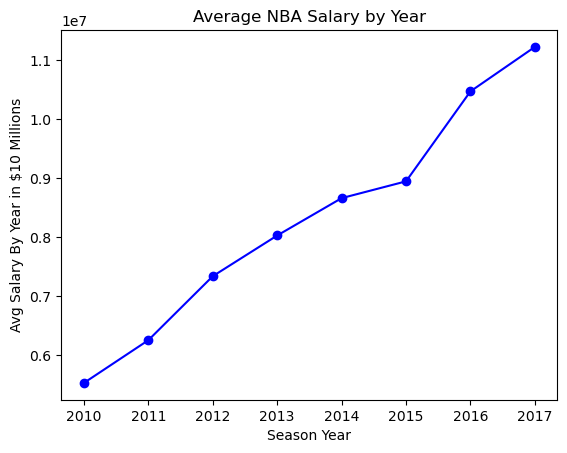

In [16]:
avg_salary_by_year = salaries_df.groupby('Season')\
    ['Salary'].mean().reset_index()

plt.plot(avg_salary_by_year['Season'],\
    avg_salary_by_year['Salary'], marker = 'o', color='blue')

plt.xlabel('Season Year')
plt.ylabel('Avg Salary By Year in $10 Millions')
plt.title('Average NBA Salary by Year')

plt.show()

The following stripplot visualizes a very similar upward progression as the plot above, but instead of visualizing only the averages per year, it shows many salary points by many different players per year. This allows for easier comprehension of things like mins, maxs, variability, and more.

Text(0.5, 1.0, 'Stripplot Visual of Salary over the Years')

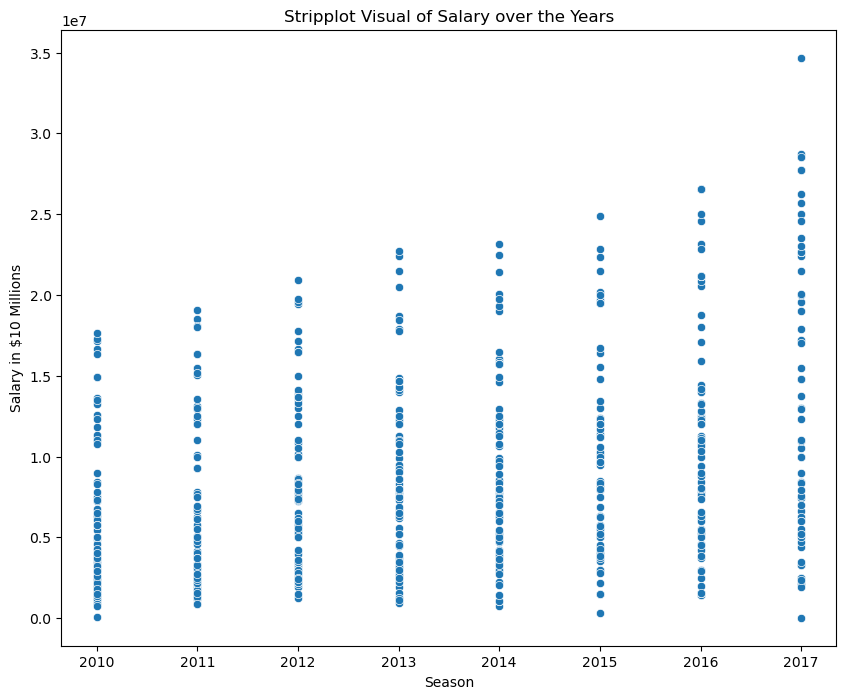

In [17]:
merged_df= pd.merge(stats_df[['Player', 'Season', 'Pos']],\
salaries_df[['Player', 'Season', 'Salary']],\
on=['Player', 'Season'], how='inner')

plt.figure(figsize=(10,8))
sns.scatterplot(data=merged_df, x='Season', y='Salary')
plt.xlabel('Season')
plt.ylabel('Salary in $10 Millions')
plt.title('Stripplot Visual of Salary over the Years')

In the following eight scatterplots, we are visually representing Salary Vs PPG by players from the 2010-2017 seasons. The x-axis is represented by Points per Game (PPG) and the y-axis is represented y Salary by $10 millions. We are starting with the relationship between PPG and salary because we believe it is the most relevant and influencial in determining a player's yearly salary. 

This scatter plot below representes the year 2010. 

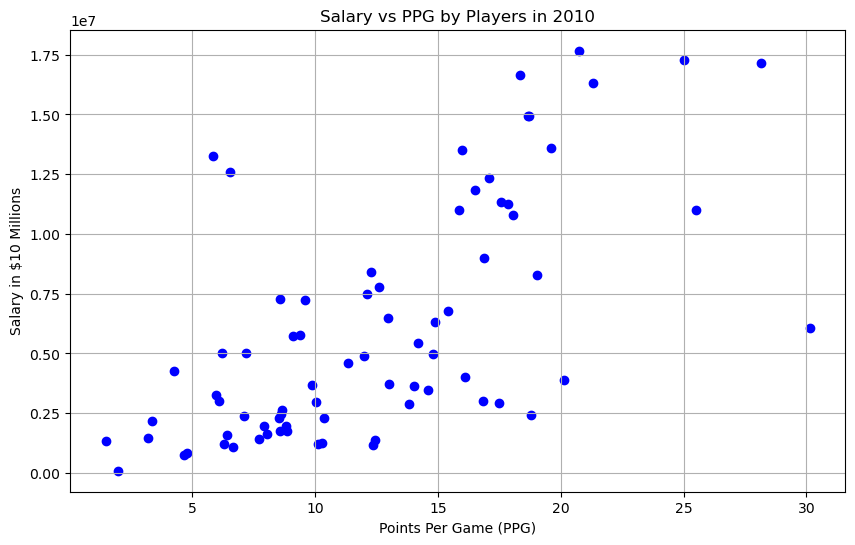

In [18]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2010_data = merged_df[merged_df['Season'] == 2010]

plt.figure(figsize=(10, 6))
plt.scatter(year_2010_data['PPG'],\
year_2010_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2010')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2011. 

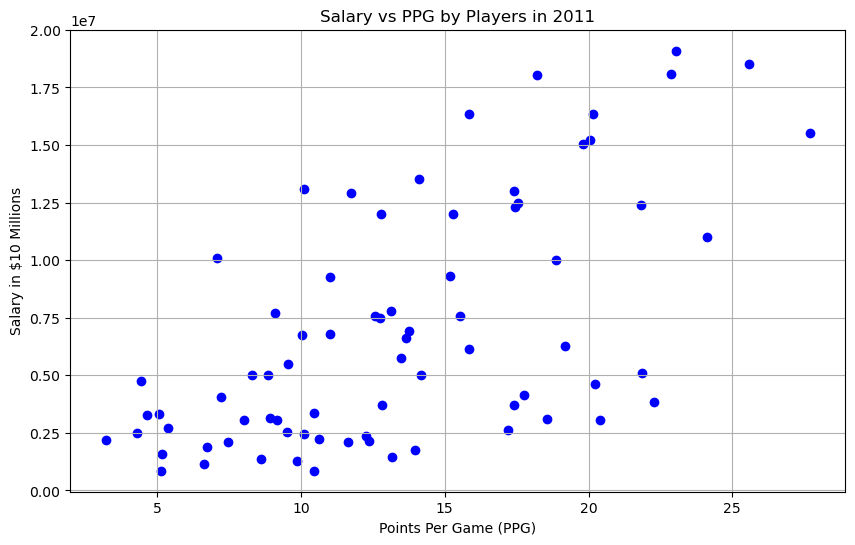

In [19]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2011_data = merged_df[merged_df['Season'] == 2011]

plt.figure(figsize=(10, 6))
plt.scatter(year_2011_data['PPG'],\
year_2011_data['Salary'], color='blue',)

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2011')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2012.

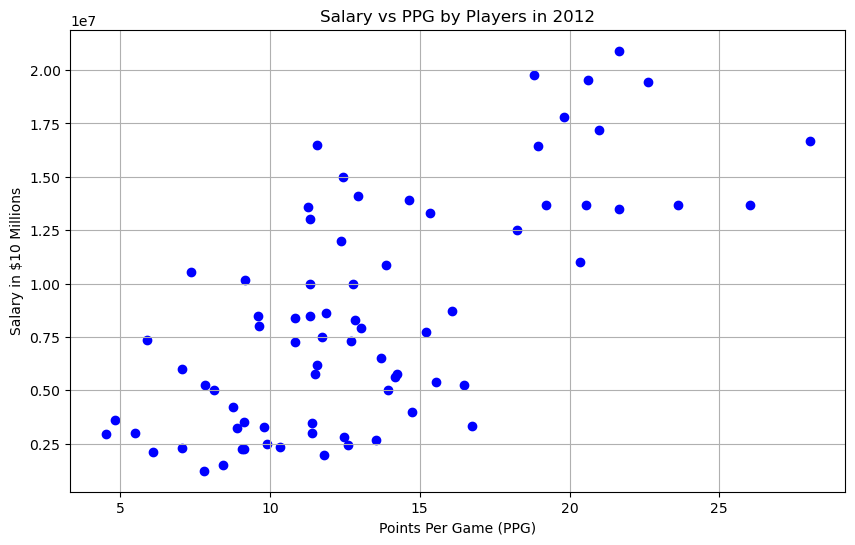

In [20]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2012_data = merged_df[merged_df['Season'] == 2012]

plt.figure(figsize=(10, 6))
plt.scatter(year_2012_data['PPG'],\
year_2012_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2012')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2013.

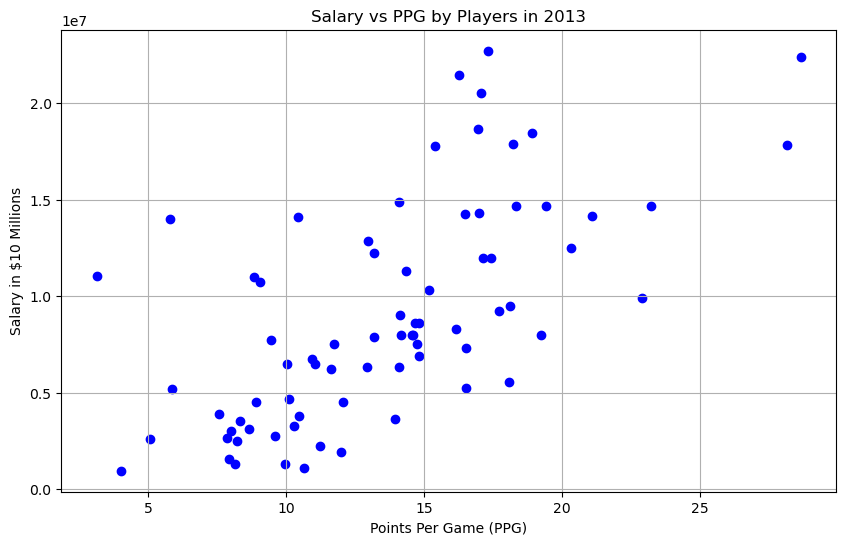

In [21]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2013_data = merged_df[merged_df['Season'] == 2013]

plt.figure(figsize=(10, 6))
plt.scatter(year_2013_data['PPG'],\
year_2013_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2013')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2014. 

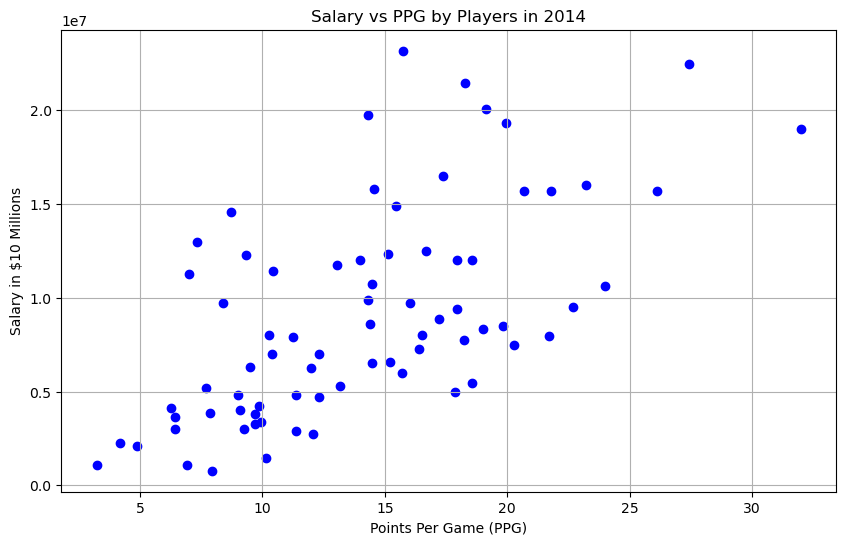

In [22]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2014_data = merged_df[merged_df['Season'] == 2014]

plt.figure(figsize=(10, 6))
plt.scatter(year_2014_data['PPG'],\
year_2014_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2014')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2015.

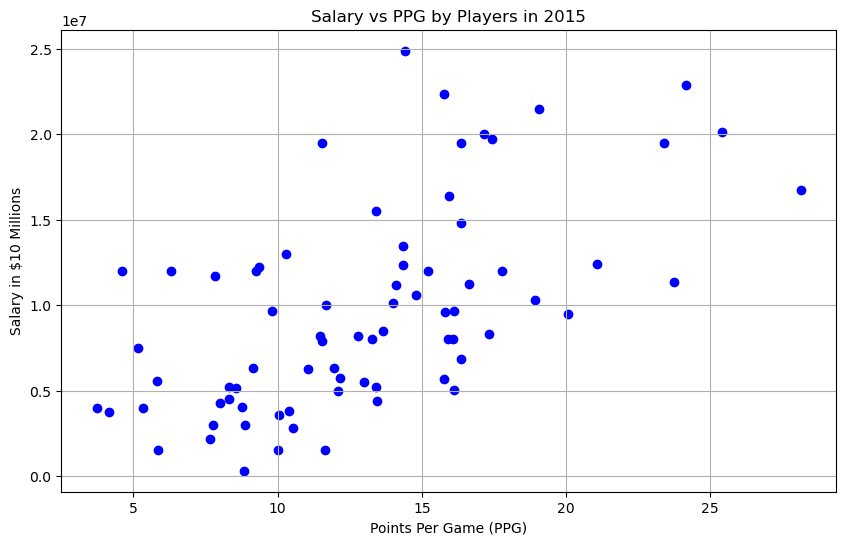

In [23]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2015_data = merged_df[merged_df['Season'] == 2015]

plt.figure(figsize=(10, 6))
plt.scatter(year_2015_data['PPG'],\
year_2015_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2015')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2016.

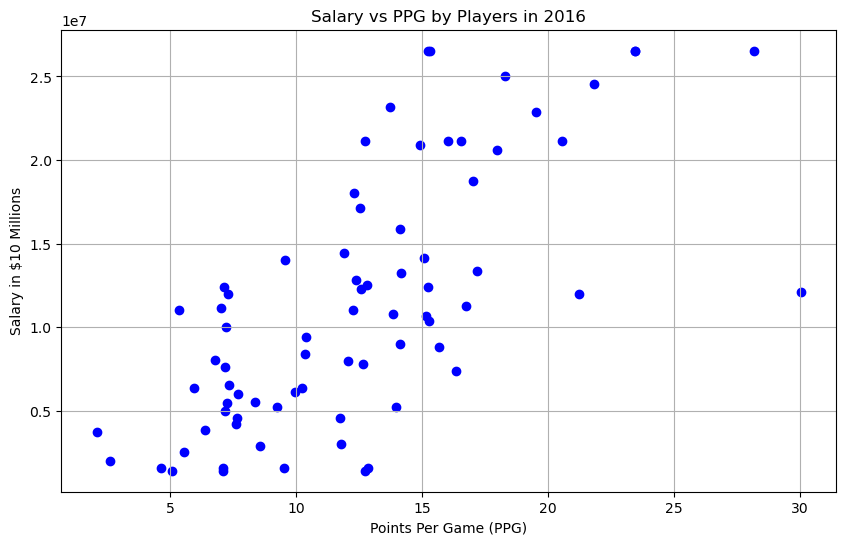

In [24]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2016_data = merged_df[merged_df['Season'] == 2016]

plt.figure(figsize=(10, 6))
plt.scatter(year_2016_data['PPG'],\
year_2016_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2016')
plt.grid(True)
plt.show()

This scatterplot below represents the year 2017. 

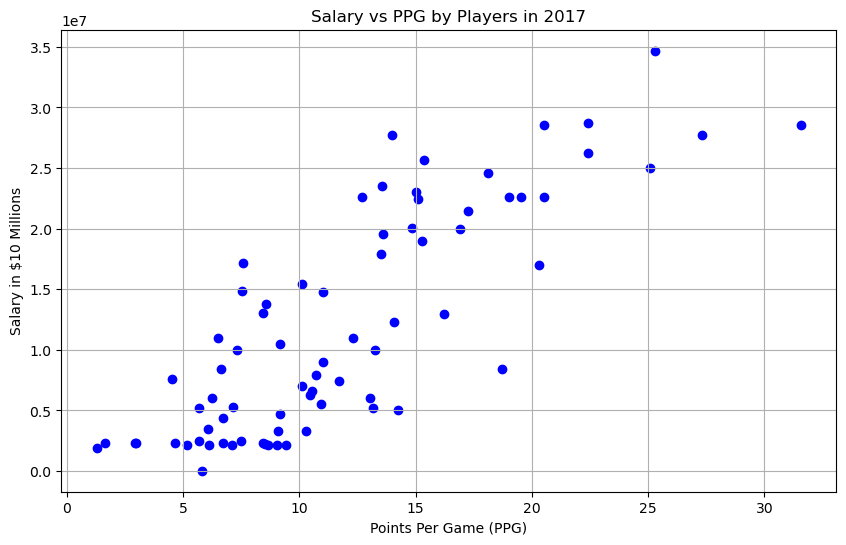

In [25]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

year_2017_data = merged_df[merged_df['Season'] == 2017]

plt.figure(figsize=(10, 6))
plt.scatter(year_2017_data['PPG'],\
year_2017_data['Salary'], color='blue')

plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players in 2017')
plt.grid(True)
plt.show()

The following scatterplot offers all the visuals above combined into one singular plot. This allows for a direct way to compare and constrast the salary increases as years go on. As shown, a majority of the earlier years are found centered on the graph or on the lower end, while the more recent years are responsible for all of the high end values. This can highly likely be explained by increase in salary caps or by the greater abundance of talent in the NBA.

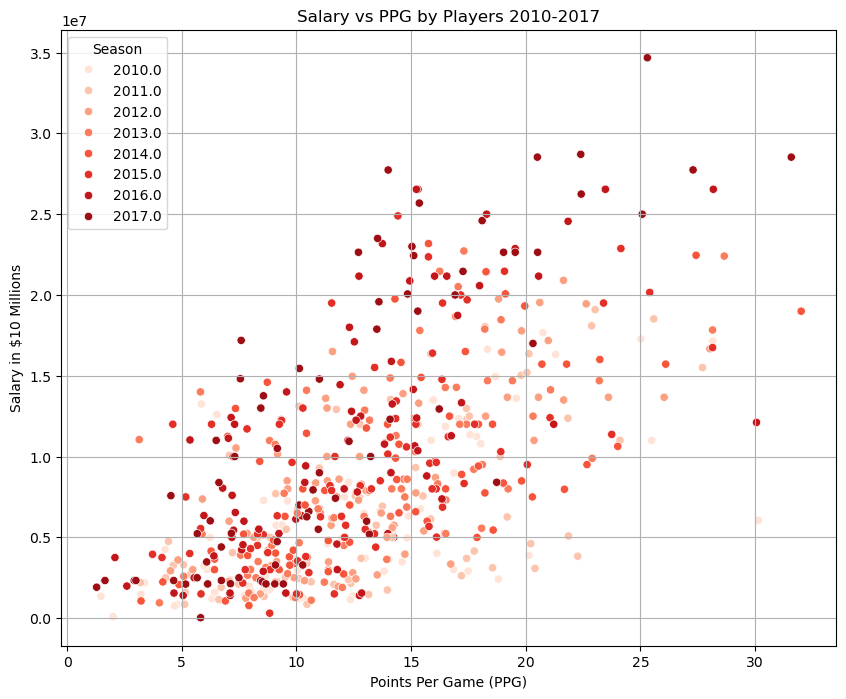

In [26]:
stats_df['PPG'] = stats_df['PTS'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

merged_df['Season'] = merged_df['Season'].astype('category')
plt.figure(figsize=(10,8))
sns.scatterplot(data=merged_df, x='PPG', y='Salary',hue='Season',palette='Reds')
plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs PPG by Players 2010-2017')
plt.grid(True)
plt.show()

The following scatterplot serves the same purpose as the plot above. This plot demonstrates the changes in salary according to the player's assist ratio per game throughout all 7 seasons that we are analyzing. As we predicted, assists do not have as big of a deciding factor when it comes to determining an NBA player's salary. The plot does still follow an positive linear progression in terms of salary/assists, but not as drastic as salary for PPG.

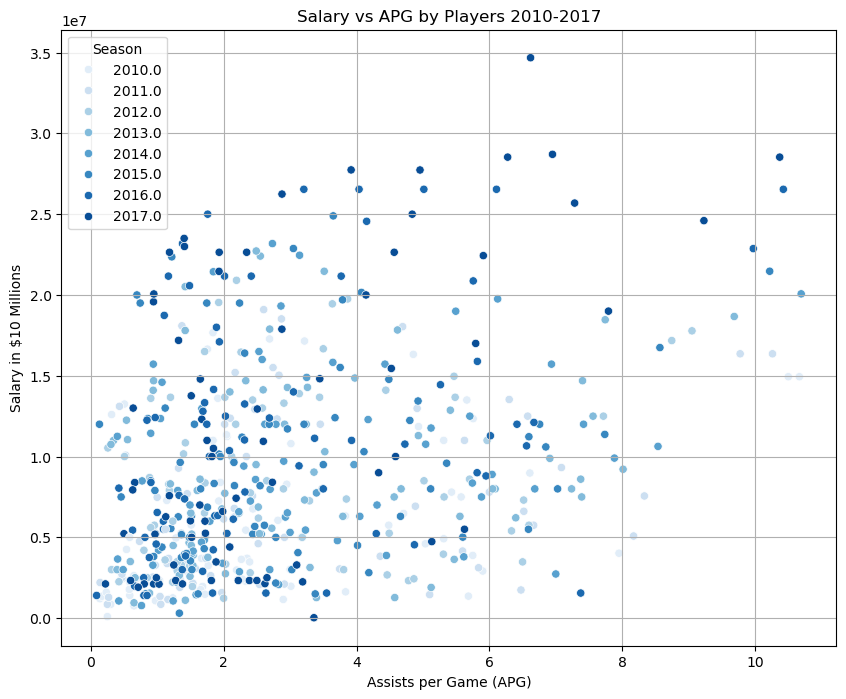

In [27]:
stats_df['APG'] = stats_df['AST'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

merged_df['Season'] = merged_df['Season'].astype('category')
plt.figure(figsize=(10,8))
sns.scatterplot(data=merged_df, x='APG', y='Salary',hue='Season',palette='Blues')
plt.xlabel('Assists per Game (APG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs APG by Players 2010-2017')
plt.grid(True)
plt.show()

The following scatterplot also serves the same purpose as the plot above. This plot demonstrates the changes in salary according to the player's block ratio per game throughout all 7 seasons that we are analyzing. Blocks per game demonstrates an even greater disparity between stats and pay. Unlike PPG and even APG, blocks do not have nearly as big of an affect on salary. There are many players who average less thatn 1 block per game getting paid near the maximum salary, while others average over 2 blocks per game, and don't earn even half that amount. A crazy outlier is seen past the 3.5 BPG mark, where a player earns one of the lowest salaries, but has the highest blocks per game statistic.

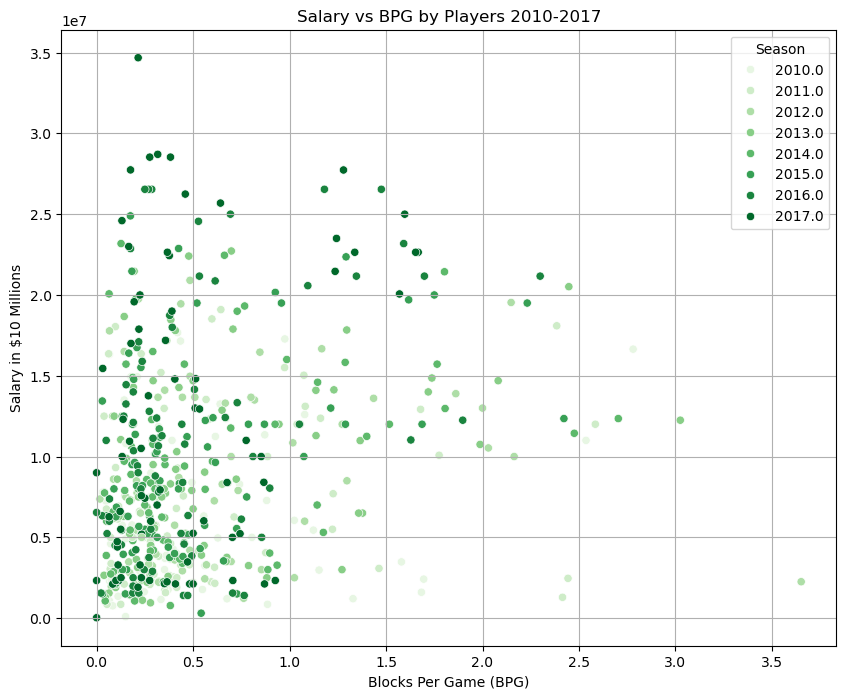

In [28]:
stats_df['BPG'] = stats_df['BLK'] / stats_df['G']

merged_df = pd.merge(stats_df, salaries_df,\
on=['Player', 'Season'], how='inner')

merged_df['Season'] = merged_df['Season'].astype('category')
plt.figure(figsize=(10,8))
sns.scatterplot(data=merged_df, x='BPG', y='Salary',hue='Season',palette='Greens')
plt.xlabel('Blocks Per Game (BPG)')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs BPG by Players 2010-2017')
plt.grid(True)
plt.show()

The following 7 stripplots offers more visuals that demonstrates the affect of player positions and their salaries.

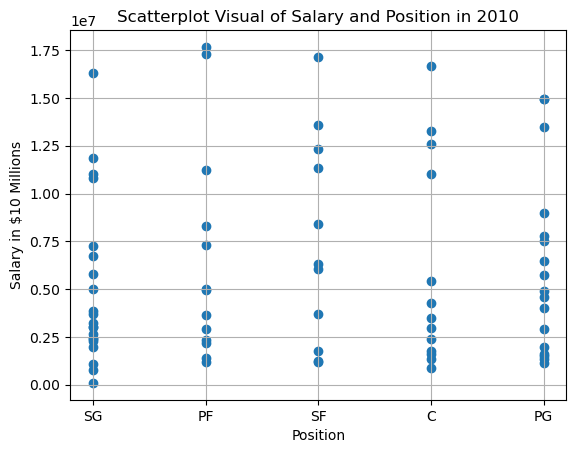

In [29]:
merged_df= pd.merge(stats_df[['Player', 'Season', 'Pos']],\
salaries_df[['Player', 'Season', 'Salary']],\
on=['Player', 'Season'], how='inner')

data2010 = merged_df[merged_df['Season'] == 2010]
plt.scatter(data=data2010, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2010')
plt.grid(True)

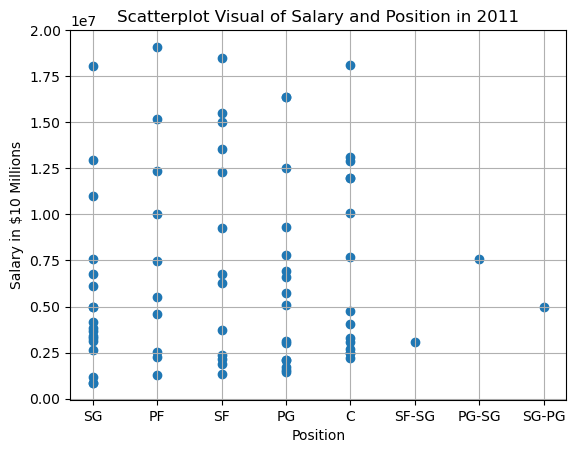

In [30]:
data2011 = merged_df[merged_df['Season'] == 2011]
plt.scatter(data=data2011, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2011')
plt.grid(True)

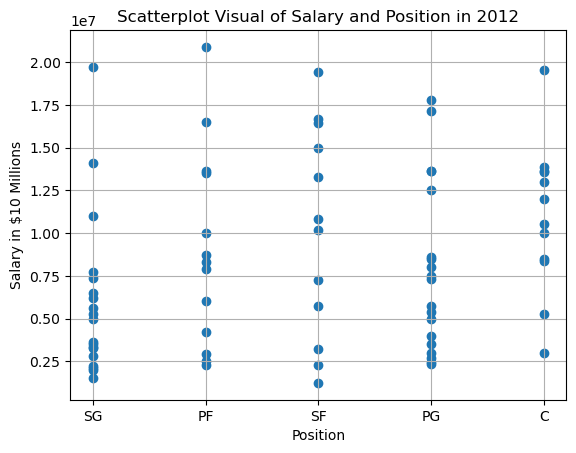

In [31]:
data2012 = merged_df[merged_df['Season'] == 2012]
plt.scatter(data=data2012, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2012')
plt.grid(True)

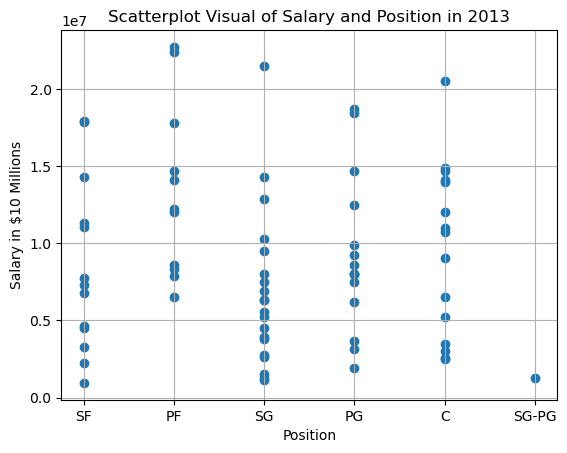

In [32]:
data2013 = merged_df[merged_df['Season'] == 2013]
plt.scatter(data=data2013, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2013')
plt.grid(True)

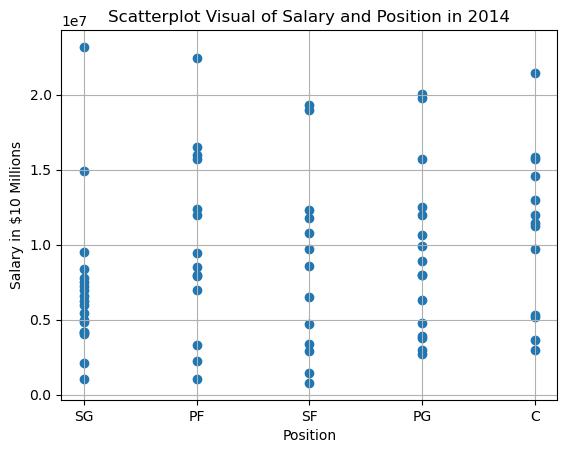

In [33]:
data2014 = merged_df[merged_df['Season'] == 2014]
plt.scatter(data=data2014, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2014')
plt.grid(True)

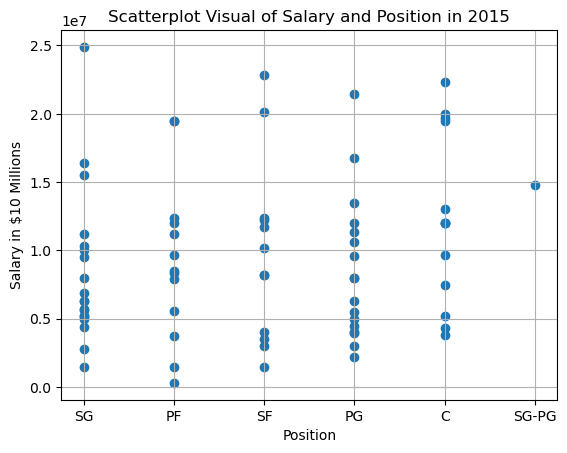

In [34]:
data2015 = merged_df[merged_df['Season'] == 2015]
plt.scatter(data=data2015, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2015')
plt.grid(True)

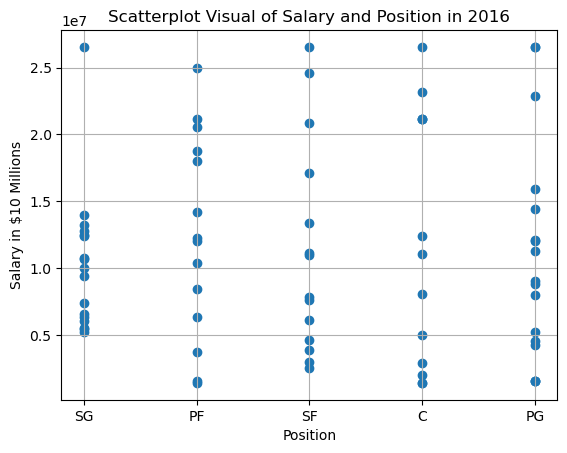

In [35]:
data2016 = merged_df[merged_df['Season'] == 2016]
plt.scatter(data=data2016, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2016')
plt.grid(True)

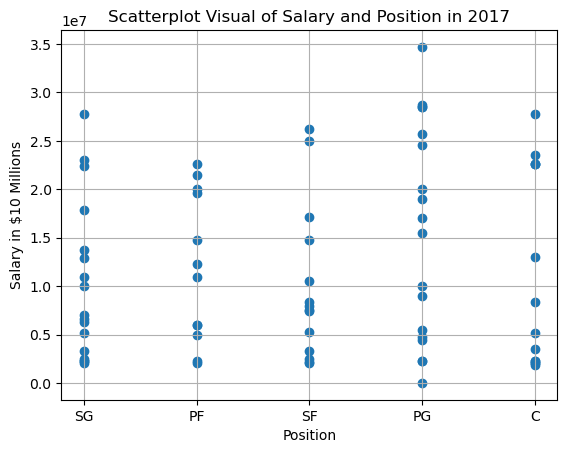

In [36]:
data2017 = merged_df[merged_df['Season'] == 2017]
plt.scatter(data=data2017, x='Pos', y='Salary')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Scatterplot Visual of Salary and Position in 2017')
plt.grid(True)

As concluded from the visuals, point guards tend to have the highest upward peaks of salaries, most likley being led by Stephen Curry, followed by shooting guards. By also analyzing the average salary by position bar graph(underneath this plot), we can see that power forwards and Centers have the highest average salary. This can be attributed to the fact that they are not as abundant as point guards or shooting guards. Players like Steph Curry or Kobe Bryant may have the highest individual salaries, but the overall salary average of their positions are brought down since there are so many players in the league that play their role as compared to the "Big Men". Additionally, rare double positions have a low average and limited sample data since they are fairly uncommon. This is a relatively rare occurance, meaning that their average and maximum salaries tend to not be high.

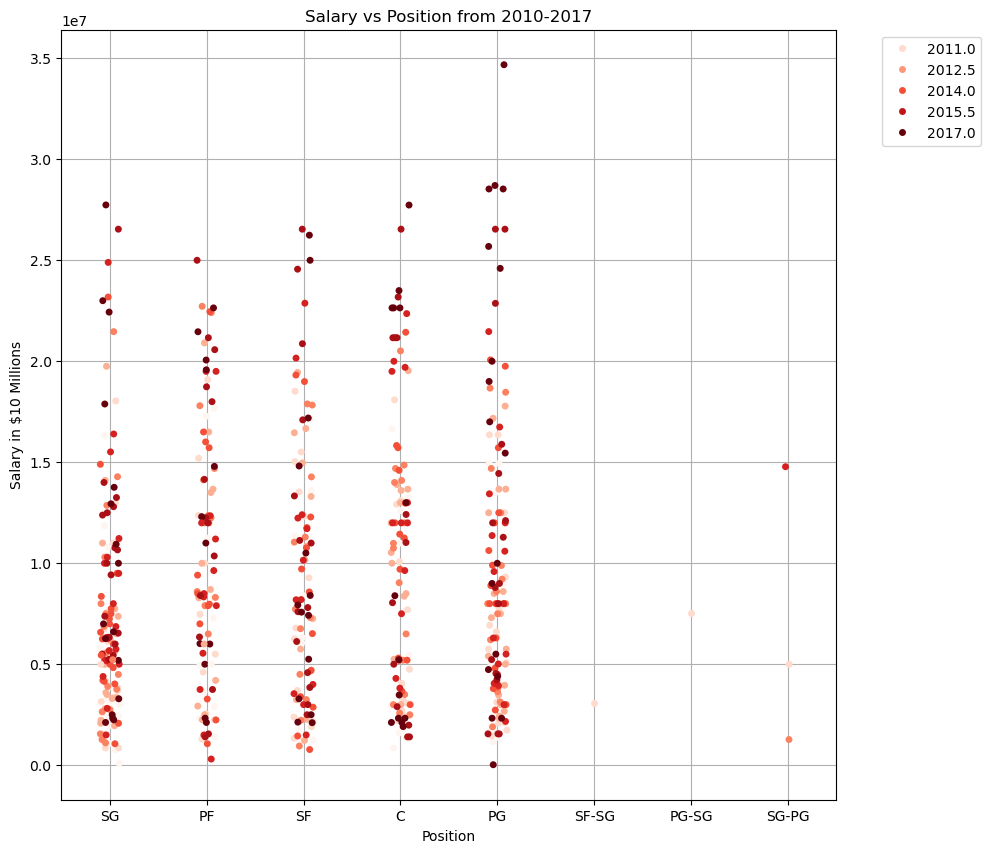

In [37]:
plt.figure(figsize=(10,10))
sns.stripplot(data=merged_df, x='Pos', y='Salary', hue='Season', palette='Reds')
plt.xlabel('Position')
plt.ylabel('Salary in $10 Millions')
plt.title('Salary vs Position from 2010-2017')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

In the following bar chart, we are visually representing the Average NBA Salary by Position. The x-axis is represented by Position and the y-axis is represented by Average Salary per Year by $10 millions. 

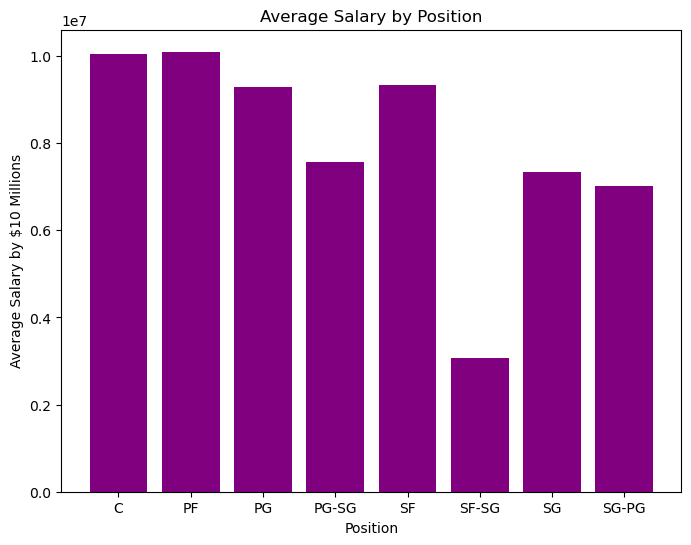

In [38]:
merged_df = pd.merge(stats_df[['Player', 'Season', 'Pos']],\
salaries_df[['Player', 'Season', 'Salary']],\
on=['Player', 'Season'], how='inner')

avg_salary_by_pos = merged_df.groupby('Pos')\
['Salary'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(avg_salary_by_pos['Pos'], \
avg_salary_by_pos['Salary'], color='purple')

plt.xlabel('Position')
plt.ylabel('Average Salary by $10 Millions')
plt.title('Average Salary by Position')

plt.show()

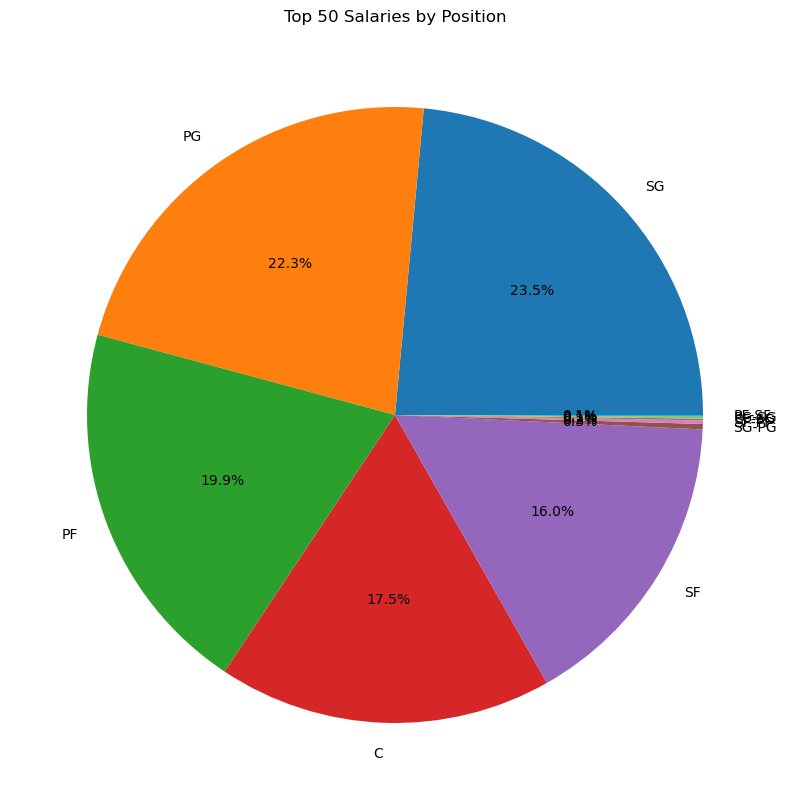

In [39]:
positions = stats_df['Pos'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(positions, labels=positions.index, \
autopct='%1.1f%%')

plt.title('Top 50 Salaries by Position')
 
plt.show()

## Questions for Reviewers

1. What does it mean by raw source data and how do we know if it is applicable to us?
2. What other types of EDA should we include?
3. Is it necessary to include charts for more variables other than PPG?
4. Should we inclue other kinds of charts to add more depth to our analysis?
5. How do we get rid of the glitch that is occurring in our pie chart?